# MPI calibration of a Grid5000 cluster

## Data exploration

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import plotnine
plotnine.options.figure_size = (12, 8)
from plotnine import *

archive_name = 'grenoble_2018-08-29_1808878.zip'

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'))['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name))
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

threshold = 64000  # "semantic" breakpoint, found with another script

# I really hate that we have to define these two values:
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

result = extract_zip(archive_name)

In [2]:
!unzip -p $archive_name info.yaml

cluster: dahu
command: /home/tocornebize/.local/bin/peanut MPICalibration run tocornebize --jobid
  grenoble:1808878 --deploy debian9-x64-base --expfile exp.csv
dahu-11.grenoble.grid5000.fr:
  arp:
    dahu-15.grenoble.grid5000.fr:
    - (172.16.20.15) at 3c:fd:fe:55:ed:60 [ether] on enp24s0f0
    dns.grenoble.grid5000.fr:
    - (172.16.31.110) at 00:16:3e:4f:65:bf [ether] on enp24s0f0
    fgrenoble.grenoble.grid5000.fr:
    - (172.16.31.101) at 00:16:3e:06:dd:61 [ether] on enp24s0f0
    gw.grenoble.grid5000.fr:
    - (172.16.31.254) at 00:04:96:1d:09:40 [ether] on enp24s0f0
    kadeploy.grenoble.grid5000.fr:
    - (172.16.31.102) at 00:16:3e:c8:38:51 [ether] on enp24s0f0
  cpu: Intel(R) Xeon(R) Gold 6130 CPU @ 2.10GHz
  gcc: 6.3.0
  kernel: 4.9.0-7-amd64
  mpi: mpirun (Open MPI) 2.0.2
  version: 'Linux version 4.9.0-7-amd64 (debian-kernel@lists.debian.org) (gcc version
    6.3.0 20170516 (Debian 6.3.0-18+deb9u1) ) #1 SMP Debian 4.9.110-3+deb9u1 (2018-08-03)'
dahu-15.grenoble.grid5000.

In [3]:
# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']
df_wtime = result['exp/exp_Wtime.csv']
df_test = result['exp/exp_Test.csv']
df_iprobe = result['exp/exp_Iprobe.csv']

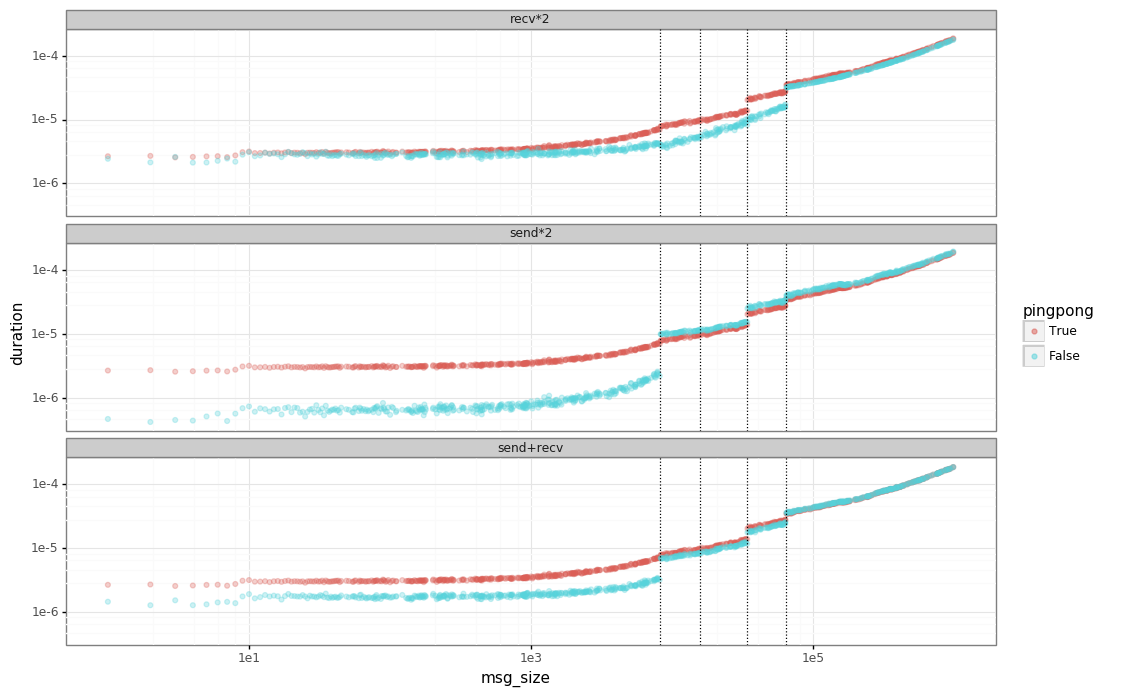

<ggplot: (-9223363292774176824)>

In [4]:
aggr_pingpong = df_pingpong.groupby('msg_size')[['duration']].mean().reset_index()
aggr_pingpong['mode'] = 'pingpong'
aggr_recv = df_recv.groupby('msg_size')[['duration']].mean().reset_index()
aggr_send = df_send.groupby('msg_size')[['duration']].mean().reset_index()

tmp = aggr_recv.copy()
tmp['duration'] *= 2
tmp['mode'] = 'recv*2'
aggr_pingpong = pandas.concat([aggr_pingpong, tmp])

tmp = aggr_send.copy()
tmp['duration'] *= 2
tmp['mode'] = 'send*2'
aggr_pingpong = pandas.concat([aggr_pingpong, tmp])

tmp = aggr_send.copy()
tmp['duration'] += aggr_recv.duration
tmp['mode'] = 'send+recv'
aggr_pingpong = pandas.concat([aggr_pingpong, tmp])

aggr_pingpong['pingpong'] = aggr_pingpong['mode'] == 'pingpong'

plot = ggplot(aes(x='msg_size', y='duration', color='pingpong')) + geom_point(aggr_pingpong[aggr_pingpong['pingpong']][['msg_size', 'duration', 'pingpong']], alpha=0.3)
plot = plot + geom_point(aggr_pingpong[~aggr_pingpong['pingpong']], alpha=0.3) + theme_bw() + scale_x_log10() + scale_y_log10() + facet_wrap('mode', nrow=3)
for bp in [8133, 15831, 33956, 64000]:
    plot += geom_vline(xintercept=bp, linetype='dotted')
plot